# Test Set Performance Evaluation

In this notebook we check the *accuracy* on the test set for the ViT model and the *confusion matrix*

In [1]:
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split


import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pathlib import Path
import pickle
# not mandatory
import io
from PIL import Image
from tqdm import tqdm

### GPU check

In [4]:
# # gpu selection
use_cuda = torch.cuda.is_available()
cuda_index = 4  # torch.cuda.device_count() -1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(device)

cuda:4


## Import the Model

In [5]:
model_path = '/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth'

In [6]:
model = torchvision.models.vit_b_16()

in_features = model.heads.head.in_features
n_classes = 100		# do we have to import the dataset only to get the number of classes or can we just put 100 cause we know it's 100?
model.heads.head = torch.nn.Linear(in_features, n_classes)

In [7]:
checkpoint = torch.load(model_path, weights_only=False, map_location='cpu')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [8]:
_ = model.to(device) # the _ = is so it wont print the entire structure of the model

## Load Data + Test Loader

Def delle funz di supporto

In [9]:
def get_dataset_config(dataset):
    dataset_config = {
        'CIFAR10': {'num_classes': 10, 
                    'input_ch': 3, 
                    'means': (0.424, 0.415, 0.384), 
                    'stds': (0.283, 0.278, 0.284)},
        
        'CIFAR100': {'num_classes': 100, 
                     'input_ch': 3, 
                     'means': (0.438, 0.418, 0.377), 
                     'stds': (0.300, 0.287, 0.294)},
        
        'ImageNet': {'num_classes': 1000, 
                     'input_ch': 3,
                     'means': [0.485, 0.456, 0.406],
                     'stds': [0.229, 0.224, 0.225]}
    }
    return dataset_config

In [10]:
# def load_data(**kwargs):
def load_data(dataset, split, augment=False, shuffle_train=False, batch_size=64, num_workers=8, seed=42, data_dir='/srv/newpenny/dataset'):
    '''
    dataset (str): choices=['CIFAR10', CIFAR100', 'ImageNet']
    '''
    dc = get_dataset_config(dataset)

    means_ = dc[dataset]['means']
    stds_ = dc[dataset]['stds']
   
    if augment and split=='train': # acts only on the training set
        transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 256)),
            transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
            transforms.CenterCrop((224, 224)),
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(means_, stds_)
        ])
    else:
        transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(means_, stds_)
        ])
          
    if dataset=='ImageNet':
        # NB. the loader doesn't work for the 'test' split
        data_path = os.path.join(data_dir, 'imagenet-1k/data')
        data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                      split=split, 
                                                      transform=transform)
    elif dataset.startswith('CIFAR'):
        data_path = os.path.join(data_dir, dataset)
        if split!='test': # data for train and val
            data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                        train=True, 
                                                        transform=transform, 
                                                        download=True)
        else:
            data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                        train=False, 
                                                        transform=transform, 
                                                        download=True)

    if split=='test':
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    else:
        # split the dataset into train and validation sets
        train_size = int(0.8 * len(data))
        val_size = len(data) - train_size
        generator = torch.Generator().manual_seed(42)
        train_data, val_data = random_split(data, [train_size, val_size], generator=generator)
        if split=='train':
            loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_train, num_workers=num_workers)
        else:
            loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return loader

In [11]:
dataset = 'CIFAR100'

# train_loader = load_data(dataset, "train", augment=True)
# val_loader = load_data(dataset, "val")

In [12]:
test_loader = load_data(dataset, "test")

Files already downloaded and verified


## Evaluation on Test Set

In [13]:
_ = model.eval()

In [14]:
correct = 0
total = 0

In [15]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0  
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)  # Move to GPU/CPU

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:26<00:00,  6.00it/s]


In [16]:
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 86.64%


### Heatmap

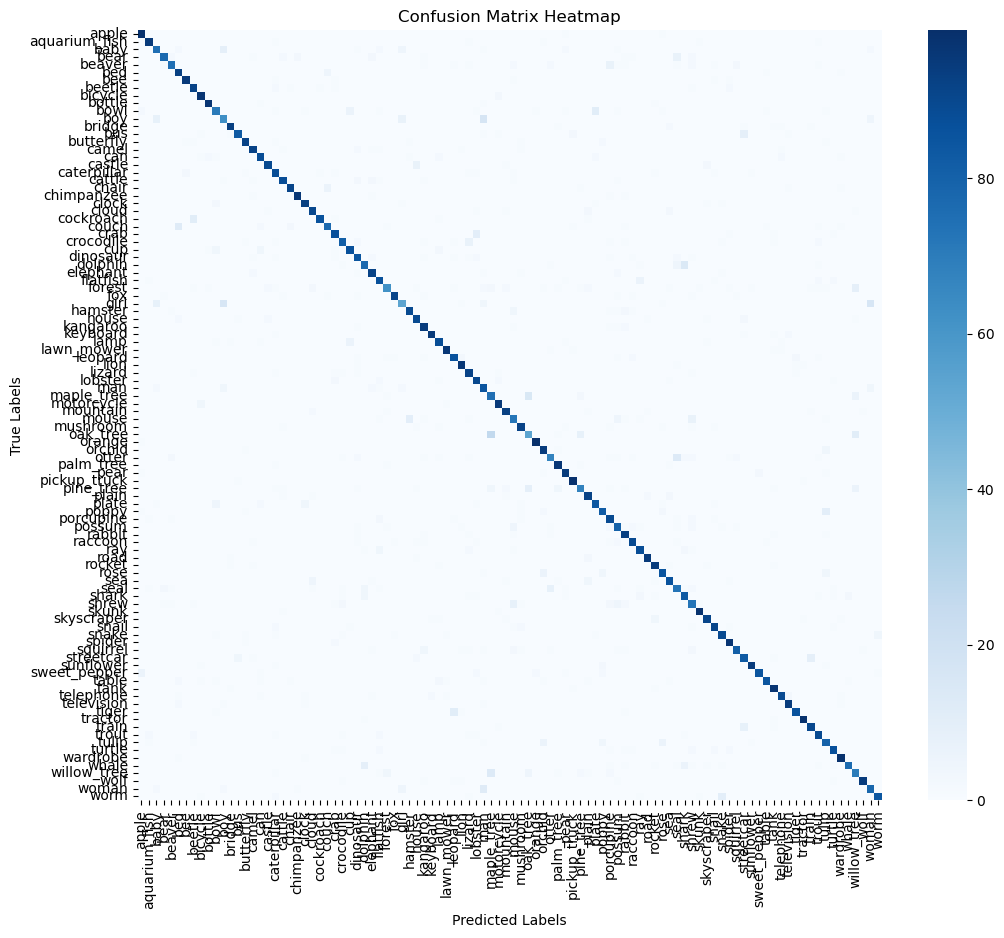

In [17]:
all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Get class names
dataset = test_loader.dataset
if isinstance(dataset, torch.utils.data.Subset):
    dataset = dataset.dataset
class_names = dataset.classes

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

## Accuracy on each class

We want to print the 3 best and the 3 worst classes

Compute the accuracy for each class in CIFAR100

In [18]:
dataset = test_loader.dataset
if isinstance(dataset, torch.utils.data.Subset):  
    dataset = dataset.dataset


In [19]:
class_names = dataset.classes
num_classes = len(class_names)

correct_per_class = np.zeros(num_classes)
total_per_class = np.zeros(num_classes)

In [20]:
print(dataset)
print(correct_per_class.shape)
print(total_per_class.shape)

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: /srv/newpenny/dataset/CIFAR100
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.438, 0.418, 0.377), std=(0.3, 0.287, 0.294))
           )
(100,)
(100,)


In [21]:
# for where we actually compute the accuracy per class
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for label, pred in zip(labels, predicted):
            total_per_class[label.item()] += 1
            if label == pred:
                correct_per_class[label.item()] += 1


In [22]:
class_accuracies = 100 * (correct_per_class / total_per_class)

In [23]:
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {class_accuracies[i]:.2f}%')

apple: 98.00%
aquarium_fish: 95.00%
baby: 75.00%
bear: 77.00%
beaver: 75.00%
bed: 93.00%
bee: 95.00%
beetle: 92.00%
bicycle: 97.00%
bottle: 97.00%
bowl: 71.00%
boy: 63.00%
bridge: 93.00%
bus: 83.00%
butterfly: 92.00%
camel: 92.00%
can: 88.00%
castle: 89.00%
caterpillar: 88.00%
cattle: 88.00%
chair: 91.00%
chimpanzee: 96.00%
clock: 93.00%
cloud: 90.00%
cockroach: 86.00%
couch: 77.00%
crab: 87.00%
crocodile: 81.00%
cup: 87.00%
dinosaur: 85.00%
dolphin: 77.00%
elephant: 92.00%
flatfish: 87.00%
forest: 62.00%
fox: 91.00%
girl: 54.00%
hamster: 89.00%
house: 89.00%
kangaroo: 94.00%
keyboard: 95.00%
lamp: 88.00%
lawn_mower: 96.00%
leopard: 86.00%
lion: 96.00%
lizard: 92.00%
lobster: 90.00%
man: 85.00%
maple_tree: 75.00%
motorcycle: 95.00%
mountain: 93.00%
mouse: 72.00%
mushroom: 92.00%
oak_tree: 54.00%
orange: 99.00%
orchid: 94.00%
otter: 67.00%
palm_tree: 96.00%
pear: 94.00%
pickup_truck: 98.00%
pine_tree: 68.00%
plain: 92.00%
plate: 84.00%
poppy: 82.00%
porcupine: 89.00%
possum: 80.00%
rabb

In [24]:
# sort classes by accuracy -> best to worst
sorted_indices = np.argsort(class_accuracies)[::-1]
print("\nClasses Sorted by Accuracy:")
for idx in sorted_indices:
    print(f"{class_names[idx]}: {class_accuracies[idx]:.2f}%")


Classes Sorted by Accuracy:
orange: 99.00%
apple: 98.00%
pickup_truck: 98.00%
skunk: 98.00%
wardrobe: 98.00%
tractor: 98.00%
bicycle: 97.00%
bottle: 97.00%
spider: 97.00%
tank: 97.00%
palm_tree: 96.00%
chimpanzee: 96.00%
lion: 96.00%
lawn_mower: 96.00%
keyboard: 95.00%
motorcycle: 95.00%
road: 95.00%
bee: 95.00%
aquarium_fish: 95.00%
sunflower: 94.00%
rocket: 94.00%
television: 94.00%
orchid: 94.00%
pear: 94.00%
wolf: 94.00%
kangaroo: 94.00%
clock: 93.00%
bridge: 93.00%
bed: 93.00%
rabbit: 93.00%
mountain: 93.00%
elephant: 92.00%
butterfly: 92.00%
lizard: 92.00%
mushroom: 92.00%
beetle: 92.00%
plain: 92.00%
camel: 92.00%
chair: 91.00%
snail: 91.00%
skyscraper: 91.00%
fox: 91.00%
train: 90.00%
cloud: 90.00%
lobster: 90.00%
trout: 89.00%
telephone: 89.00%
hamster: 89.00%
house: 89.00%
porcupine: 89.00%
raccoon: 89.00%
castle: 89.00%
snake: 89.00%
can: 88.00%
lamp: 88.00%
caterpillar: 88.00%
ray: 88.00%
cattle: 88.00%
flatfish: 87.00%
crab: 87.00%
cup: 87.00%
turtle: 87.00%
tiger: 86.00%

### Superclass

Accuracy per superclass

In [25]:
# -> class: superclass
fine_to_coarse ={4: 0, 30: 0, 55: 0, 72: 0, 95: 0,
                 1: 1, 32: 1, 67: 1, 73: 1, 91: 1,
                 54: 2, 62: 2, 70: 2, 82: 2, 92: 2,
                 9: 3, 10: 3, 16: 3, 28: 3, 61: 3,
                 0: 4, 51: 4, 53: 4, 57: 4, 83: 4,
                 22: 5, 39: 5, 40: 5, 86: 5, 87: 5,
                 5: 6, 20: 6, 25: 6, 84: 6, 94: 6,
                 6: 7, 7: 7, 14: 7, 18: 7, 24: 7,
                 3: 8, 42: 8, 43: 8, 88: 8, 97: 8,
                 12: 9, 17: 9, 37: 9, 68: 9, 76: 9,
                 23: 10, 33: 10, 49: 10, 60: 10, 71: 10,
                 15: 11, 19: 11, 21: 11, 31: 11, 38: 11,
                 34: 12, 63: 12, 64: 12, 66: 12, 75: 12,
                 26: 13, 45: 13, 77: 13, 79: 13, 99: 13,
                 2: 14, 11: 14, 35: 14, 46: 14, 98: 14,
                 27: 15, 29: 15, 44: 15, 78: 15, 93: 15,
                 36: 16, 50: 16, 65: 16, 74: 16, 80: 16,
                 47: 17, 52: 17, 56: 17, 59: 17, 96: 17,
                 8: 18, 13: 18, 48: 18, 58: 18, 90: 18,
                 41: 19, 69: 19, 81: 19, 85: 19, 89: 19}

In [26]:
class_names = dataset.classes
num_classes = len(class_names)

correct_per_class = np.zeros(num_classes)
total_per_class = np.zeros(num_classes)

In [27]:
sup_total = np.zeros(20)            # find where the value 20 for the superclass is stored
sup_total_correct = np.zeros(20)

In [28]:
# for where we actually compute the accuracy per class
flag = True

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # analyze every single image
        for label, pred in zip(labels, predicted):
            
            total_per_class[label.item()] += 1
            sup_total[fine_to_coarse[label.item()]] +=1

            if label == pred:
                correct_per_class[label.item()] += 1
                sup_total_correct[fine_to_coarse[label.item()]] += 1
            
            # if flag:

            #     flag = False
            #     print(label.item())
            #     print(pred.item())

In [29]:
sup_total

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500.])

In [30]:
sup_total_correct

array([368., 442., 435., 427., 468., 459., 444., 453., 439., 457., 423.,
       462., 447., 449., 355., 434., 408., 363., 463., 468.])

In [31]:
sup_class_acc = 100 * (sup_total_correct / sup_total)

In [32]:
superclass_names = [
    "Aquatic Mammals", "Fish", "Flowers", "Food Containers", "Fruit and Vegetables",
    "Household Electrical Devices", "Household Furniture", "Insects", "Large Carnivores", "Large Man-made Outdoor Things",
    "Large Natural Outdoor Scenes", "Large Omnivores and Herbivores", "Medium-sized Mammals", "Non-insect Invertebrates",
    "People", "Reptiles", "Small Mammals", "Trees", "Vehicles 1", "Vehicles 2"
]

In [33]:
sorted_indices = np.argsort(sup_class_acc)[::-1]

print("\nSuperclasses Sorted by Accuracy:\n")
print(f"{'Superclass':<35}{'Accuracy (%)':>10}")
print("-" * 50)

for idx in sorted_indices:
    print(f"{superclass_names[idx]:<35}{sup_class_acc[idx]:>10.2f}%")



Superclasses Sorted by Accuracy:

Superclass                         Accuracy (%)
--------------------------------------------------
Vehicles 2                              93.60%
Fruit and Vegetables                    93.60%
Vehicles 1                              92.60%
Large Omnivores and Herbivores          92.40%
Household Electrical Devices            91.80%
Large Man-made Outdoor Things           91.40%
Insects                                 90.60%
Non-insect Invertebrates                89.80%
Medium-sized Mammals                    89.40%
Household Furniture                     88.80%
Fish                                    88.40%
Large Carnivores                        87.80%
Flowers                                 87.00%
Reptiles                                86.80%
Food Containers                         85.40%
Large Natural Outdoor Scenes            84.60%
Small Mammals                           81.60%
Aquatic Mammals                         73.60%
Trees               

#### Super class heatmap

In [34]:
all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [35]:
len(all_preds)

10000

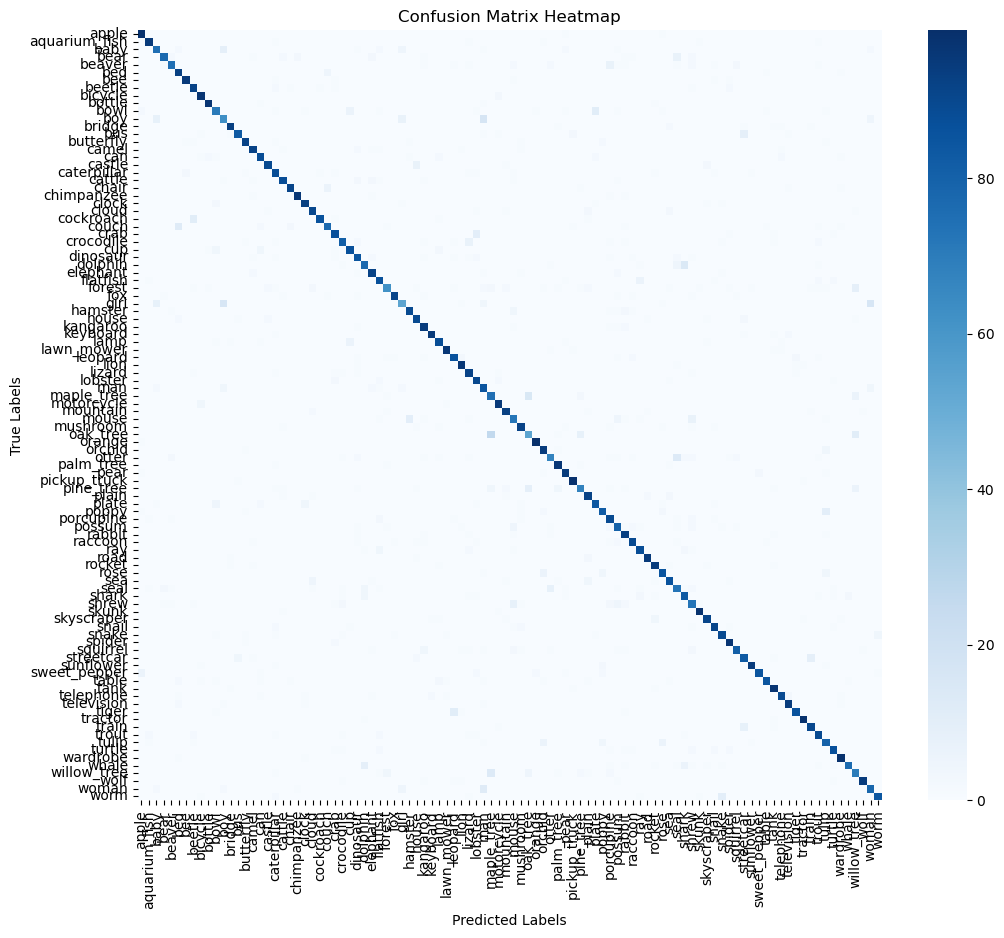

In [36]:


# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Get class names
dataset = test_loader.dataset
if isinstance(dataset, torch.utils.data.Subset):
    dataset = dataset.dataset
class_names = dataset.classes

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [37]:
# Initialize superclass confusion matrix
num_superclasses = 20
conf_matrix_superclass = np.zeros((num_superclasses, num_superclasses))

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Convert fine labels to superclasses and update confusion matrix
        for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            coarse_label = fine_to_coarse[label]  # True superclass
            coarse_pred = fine_to_coarse[pred]    # Predicted superclass
            conf_matrix_superclass[coarse_label, coarse_pred] += 1

In [38]:
# Normalize confusion matrix (optional)
conf_matrix_superclass = conf_matrix_superclass / conf_matrix_superclass.sum(axis=1, keepdims=True)

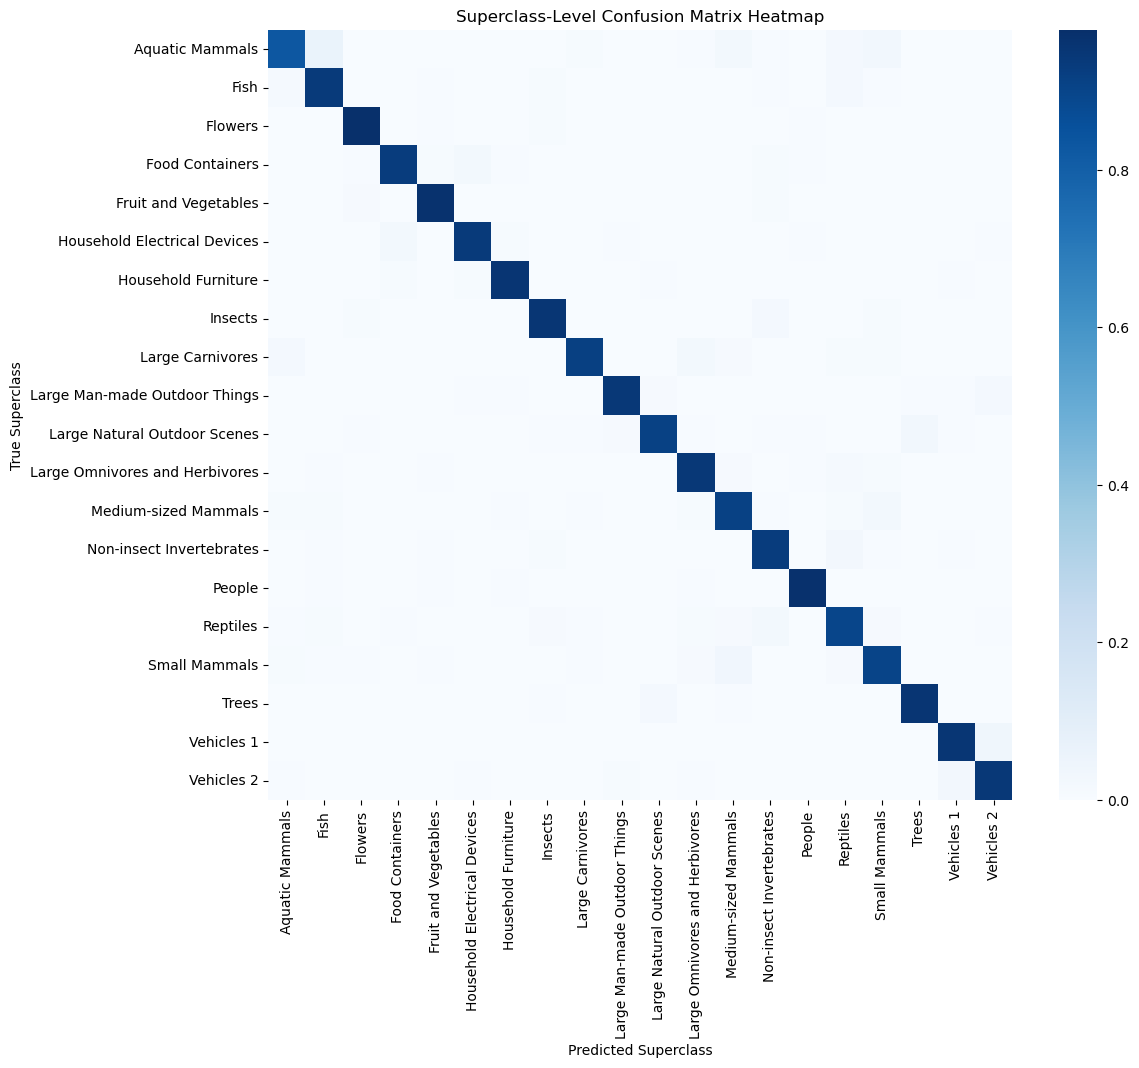

In [39]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_superclass, annot=False, cmap="Blues", xticklabels=superclass_names, yticklabels=superclass_names)
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Superclass-Level Confusion Matrix Heatmap")
plt.show()